# Convolutional Neural Networks

For this homework you will train a CNN on the Hymenoptera dataset that you can download from here:

- https://download.pytorch.org/tutorial/hymenoptera_data.zip

You will code any CNN architecture that you want for this, using pytorch and/or pytorch-lightning (you can use only pytorch is you want)

## Load the dataset

**QUESTION.** Load the dataset into two dataloaders, one from training and the other for validation.

- You can use `torchvision.datasets.ImageFolder` and pass it to `DataLoader` for this, have a look at the documentation
- In the transformations, you should resize the images to make things faster (using the size of CIFAR-10's images for instance), and use some data augmentation (only for the training dataloader, of course) 

In [ ]:
**QUESTION.** Display some images and their associated labels. You should see images of bees and ants :)

In [6]:
import zipfile as zf
files = zf.ZipFile("hymenoptera_data.zip", 'r')
files.extractall('./')
files.close()

In [96]:
import torchvision
import torchvision.transforms as transforms
import torch

transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.RandomVerticalFlip(0.5), 
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor()                                 
    ])

transform_bis = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()                                 
    ])

train = torchvision.datasets.ImageFolder('./hymenoptera_data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(train, batch_size=5, num_workers=16, shuffle=True)

test = torchvision.datasets.ImageFolder('./hymenoptera_data/val', transform=transform_bis)
testloader = torch.utils.data.DataLoader(test, batch_size=64, num_workers=16, shuffle=True)

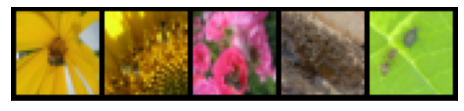

In [98]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()

trainloader_iter = iter(trainloader)
images, labels = next(trainloader_iter)
show_images(torchvision.utils.make_grid(images))

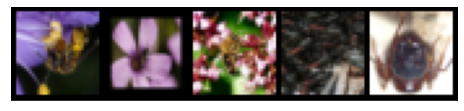

In [99]:
images, labels = next(trainloader_iter)
show_images(torchvision.utils.make_grid(images))

In [100]:
classes = train.classes

In [101]:
images.shape

torch.Size([5, 3, 32, 32])

## Neural net architecture

You are free to define any kind of convolutional neural network that you think is reasonable for today's problem.
Remember that convolutional neural networks are usually a combination of the following building blocks:

  * Convolutional layers
  * Pooling layers
  * Linear layers
  
It is your task today to arrange these components into a reasonable architecture.

In [25]:
!pip install pytorch-lightning

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 52.0.0.post20210125
    Uninstalling setuptools-52.0.0.post20210125:
      Successfully uninstalled setuptools-52.0.0.post20210125
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.9.0
    Uninstalling fsspec-0.9.0:
      Successfully uninstalled fsspec-0.9.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


In [102]:
import torch.nn.functional as F

class CNN(nn.Module):

    def __init__(self):

        super(CNN, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
               
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=128*3*3, out_features=256),
            nn.Dropout2d(0.25),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.Linear(in_features=128, out_features=2)
                    
        )
                    
        

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x


In [103]:
net = CNN()
x = torch.randn(5, 3, 32, 32)
out = net(x)
out.size()

torch.Size([5, 2])

## Training loop and checks

**QUESTION**. Code the training loop (specify the loss, etc.). Check that everything is fine, that the forward pass works and that training on a very small subset of the data works as well. Add the callbacks that you want, and prepare the logging tools that you want to use (such as tensorboard, or anything you want to use.

In [115]:
import torch.optim as optim

model = CNN()
criterion = nn.CrossEntropyLoss()
num_epochs = 7
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [116]:
def train(model, num_epochs, dataloaders):
    for epoch in range(num_epochs):  
        
        faux = 0
        correct = 0

        running_loss = 0.0
        for i, data in enumerate(dataloaders, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            faux += loss.item() * images.size(0)
            correct += torch.sum(preds == labels.data)
            
        epoch_loss = faux / len(dataloaders.dataset)
        epoch_acc = correct / len(dataloaders.dataset)
        
        print('Epochs {}, Loss: {:.5f} Acc: {:.5f}'.format(epoch, epoch_loss, epoch_acc))

    print('Finished Training')
            

In [79]:
train(model,num_epochs, trainloader)

Epochs 0 | Loss: 0.7008 Acc: 0.4918
Epochs 1 | Loss: 0.6848 Acc: 0.5492
Epochs 2 | Loss: 0.7190 Acc: 0.4918
Epochs 3 | Loss: 0.6953 Acc: 0.5246
Epochs 4 | Loss: 0.6893 Acc: 0.5656
Epochs 5 | Loss: 0.6806 Acc: 0.5697
Epochs 6 | Loss: 0.6858 Acc: 0.6025
Finished Training


## Measure the performance of you model

Measure the performance of your model, and display some things (such as confusion matrix, ROC or AUC curves).
Compare several architectures, put your results in an easy to interpret pandas dataframe.

In [15]:
!pip install scikit-plot

In [80]:
def get_predictions(model, loader):
    all_preds = torch.tensor([]).detach()
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds.detach()

In [84]:
def test_perf_acc(model, loader):
    accuracy = 0
    totl = 0
    good = 0
    for images, labels in loader:
        outputs = model(images)
        _, preds = torch.max(outputs.data, 1)
        totl += labels.size(0)
        good += (preds == labels).sum()
        
        accuracy = 100 * good / totl
    print('Accuracy :  {}'.format(accuracy))

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import scikitplot as skplt

predictions = get_predictions(model, testloader)
scores = F.softmax(predictions, dim=1)

test_perf_acc(model, testloader)

C:\Users\Rayann\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy :  50.98039245605469


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

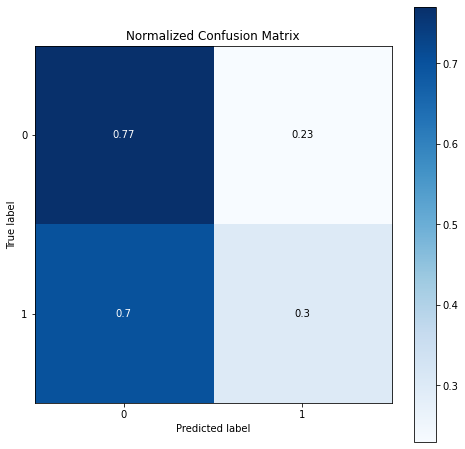

In [88]:
skplt.metrics.plot_confusion_matrix(test.targets, scores.argmax(dim=1), normalize=True, figsize=(8, 8))

## Use fine-tuning and transfer learning

You might have noticed that training a CNN from scratch can be very slow, hard, painful, and that the overall performance might not be satisfying. 

**QUESTION.** To overcome this, use a pre-trained network and fine-tune it on the Hymenoptera dataset.
You are free to choose any pre-trained model that the PyTorch library offers evaluate and compare its performance to the CNN you have built yourself.

In [126]:
train_ = torchvision.datasets.ImageFolder(
    root = './hymenoptera_data/train/',
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomVerticalFlip(0.5), 
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor()                                 
    ])
)

test_ = torchvision.datasets.ImageFolder(
    root = './hymenoptera_data/val/',
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()                                 
    ])
)

trainloader = torch.utils.data.DataLoader(train_, batch_size=5, num_workers=4, shuffle=True)
testloader = torch.utils.data.DataLoader(test_, batch_size=64, num_workers=4)

classes = train_.classes

In [128]:
def get_param(model) :
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return params_to_update

net = models.resnet18(pretrained=True)

for param in net.parameters():
    param.requires_grad = False

net.fc=nn.Linear(net.fc.in_features, 2)
            
optimizer = optim.Adam(get_param(net))

train(net, 15, trainloader)

Epochs 0, Loss: 0.76462 Acc: 0.56148
Epochs 1, Loss: 0.47209 Acc: 0.77459
Epochs 2, Loss: 0.46297 Acc: 0.75410
Epochs 3, Loss: 0.44152 Acc: 0.77459
Epochs 4, Loss: 0.36529 Acc: 0.81967
Epochs 5, Loss: 0.36899 Acc: 0.85656
Epochs 6, Loss: 0.34078 Acc: 0.82787
Epochs 7, Loss: 0.28170 Acc: 0.87295
Epochs 8, Loss: 0.36239 Acc: 0.82787
Epochs 9, Loss: 0.34023 Acc: 0.85246
Epochs 10, Loss: 0.29045 Acc: 0.87295
Epochs 11, Loss: 0.28474 Acc: 0.88115
Epochs 12, Loss: 0.27221 Acc: 0.86475
Epochs 13, Loss: 0.27410 Acc: 0.86885
Epochs 14, Loss: 0.38003 Acc: 0.85656
Finished Training


In [130]:
predictions = get_predictions(net, testloader)
scores = F.softmax(predictions, dim=1)

test_perf_acc(net, testloader)

Accuracy :  59.47712326049805


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

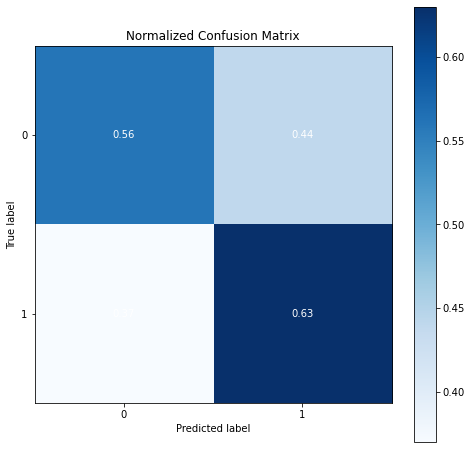

In [131]:
skplt.metrics.plot_confusion_matrix(test.targets, scores.argmax(dim=1), normalize=True, figsize=(8, 8))